In [202]:
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np 
import os 
import yaml 
import pyam 
import seaborn as sns
import sys
sys.path.append('..')
from plot_fair_share_cat import * 

# Read in data files

In [2]:
output_path = os.path.join(
    '..',
    'data',
    'cat_output'
)

In [3]:
os.listdir(output_path)

['210216_range_p5_proc_CAT_EU27_rescaled.xlsx',
 '210216_proc_CAT_EU27.xlsx',
 '210217_range_p0_proc_CAT_EU27_rescaled.xlsx',
 '210216_proc_CAT_EU27_rescaled.xlsx',
 'input_equity_210216.csv',
 '210218_cdf_proc_CAT_EU27_rescaled.xlsx']

In [4]:
mm_line = pd.read_excel(
    os.path.join(output_path, '210217_range_p0_proc_CAT_EU27_rescaled.xlsx')
).set_index(['region','scenario'])

In [5]:
mm_dist = pd.read_excel(
    os.path.join(output_path, '210218_cdf_proc_CAT_EU27_rescaled.xlsx')
).set_index(['region','scenario'])

In [6]:
quant_line = pd.read_excel(
    os.path.join(output_path, '210216_proc_CAT_EU27_rescaled.xlsx')
).set_index(['region','scenario'])

In [7]:
region_mapping = pd.read_csv(
    os.path.join('mapping','default_mapping.csv')
).set_index('ISO')

In [8]:
historic_data = pd.read_csv(
    os.path.join('..','data','input','Historic_data_per_country_EU27.csv'),
    index_col = 0
)

# Aggregate to the R5 level for comparison 

In [9]:
hist_2010 = historic_data['2010']
earth_2010 = 43710 # From PRIMAP-Hist

In [10]:
def q25(x):
    return x.quantile(0.25)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

In [11]:
def construct_reduction_statistics(df, scenario):
    """Function to calculate reduction below 2010 levels"""
    
    # Obtain the necessary data
    df_1p5 = df[
        df.index.get_level_values('scenario') == '2100_GMT<1.5C@P0.5'
    ].droplevel('scenario')
    
    for ix in df_1p5.index:
        try:
            df_1p5.loc[ix,:] = (df_1p5.loc[ix,:] / hist_2010.loc[ix] - 1) * 100
        except:
            print(ix)
    
    # Filter out for valid countries
    df_1p5 = df_1p5[df_1p5.index.isin(region_mapping.index)]
    df_1p5.index = df_1p5.index.map(lambda x: region_mapping.loc[x,'R5_region'])
    
    # Create a result frame
    result = df_1p5['2030_allowances'].groupby('region').agg(['median','mean',q25,q75])
    result['scenario'] = scenario
    
    return result

In [12]:
construct_reduction_statistics(mm_line,'mm_line')

EARTH


median        mean         q25         q75 scenario
region                                                         
R5ASIA   15.085376   42.203712  -30.690003  114.532134  mm_line
R5LAM   -15.285128    2.809753  -33.331963   11.585642  mm_line
R5MAF   206.747465  447.466080   10.434969  637.428111  mm_line
R5OECD  -90.707426 -115.377962 -131.732313  -62.686151  mm_line
R5REF    22.433233   44.143385  -15.523062   71.535249  mm_line

In [13]:
df_scen = [
    (mm_line,'mm_line'),
    (mm_dist,'mm_dist'),
    (quant_line,'quant_line')
]

In [14]:
result = pd.DataFrame()
for d,s in df_scen:
    result = result.append(construct_reduction_statistics(d,s))

EARTH
EARTH
EARTH


In [15]:
result

median        mean         q25         q75    scenario
region                                                            
R5ASIA   15.085376   42.203712  -30.690003  114.532134     mm_line
R5LAM   -15.285128    2.809753  -33.331963   11.585642     mm_line
R5MAF   206.747465  447.466080   10.434969  637.428111     mm_line
R5OECD  -90.707426 -115.377962 -131.732313  -62.686151     mm_line
R5REF    22.433233   44.143385  -15.523062   71.535249     mm_line
R5ASIA   10.574945   15.418828  -22.245178   42.908881     mm_dist
R5LAM   -12.538595   -9.427072  -31.912023    4.935484     mm_dist
R5MAF    44.786762   40.929164   -0.322576   75.854923     mm_dist
R5OECD  -58.680052  -52.017383  -67.880766  -48.850470     mm_dist
R5REF    -8.064291   -5.463548  -35.858781    3.986673     mm_dist
R5ASIA   20.091361   26.255847  -24.750848   93.738965  quant_line
R5LAM   -16.441231   -2.563937  -34.846016   17.728807  quant_line
R5MAF   113.462658  351.400113    3.130785  547.272839  quant_line
R5OECD  -86.063047  -83.238862 -115.697754  -57.470320  quant_line
R5REF     0.375479    1.262349  -29.212136   29.138344  quant_line

# NDC plots per country 

In [16]:
df_hist = pd.read_csv(
        '../data/input/Historic_data_per_country_EU27.csv',
        index_col = 0
)
ndc_data = pd.read_excel(
    '../data/input/ndc_data.xlsx',
    index_col = 'iso'
)

In [17]:
def plot_fair_share_ndc(iso,save=True):
    """Function to plot NDC and target"""

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5), sharey=True)
    plot_fair_share_cat(df_hist, ndc_data, mm_line, iso, ax1)
    plot_fair_share_cat(df_hist, ndc_data, mm_dist, iso, ax2)
    plot_fair_share_cat(df_hist, ndc_data, quant_line, iso, ax3)

    ax1.get_legend().remove()
    ax3.get_legend().remove()
    ax2.legend(bbox_to_anchor = (1.4,-0.1), ncol=5)

    ax1.set_title('Case: mm_line')
    ax2.set_title('Case: mm_dist')
    ax3.set_title('Case: quant_line')

    if save:
        fig.savefig(
            '../figures/{}_fs_range_papeer.png'.format(iso),
            dpi=600,
            bbox_inches='tight'
        )

In [18]:
countries_to_analyze = [
    'IND',
    'CHN',
    'EU27',
    'ZAF',
    'RUS',
    'CRI'
]

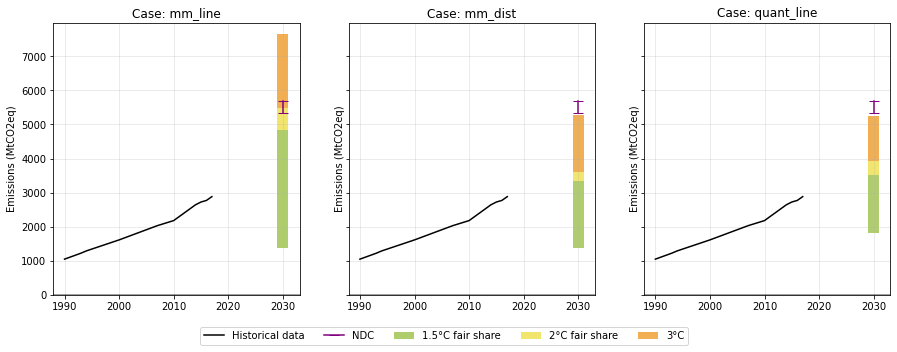

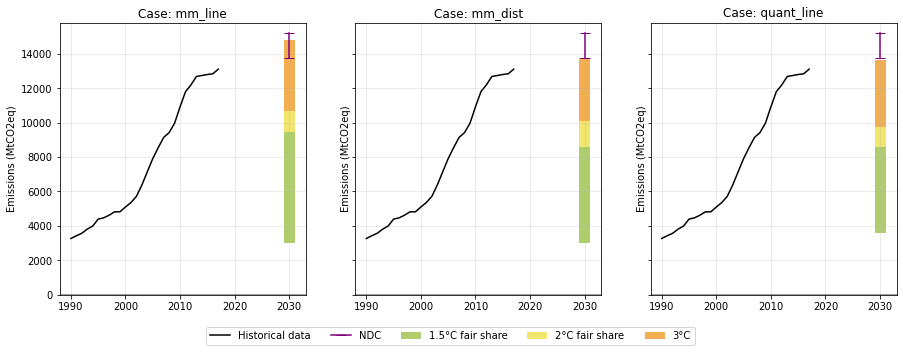

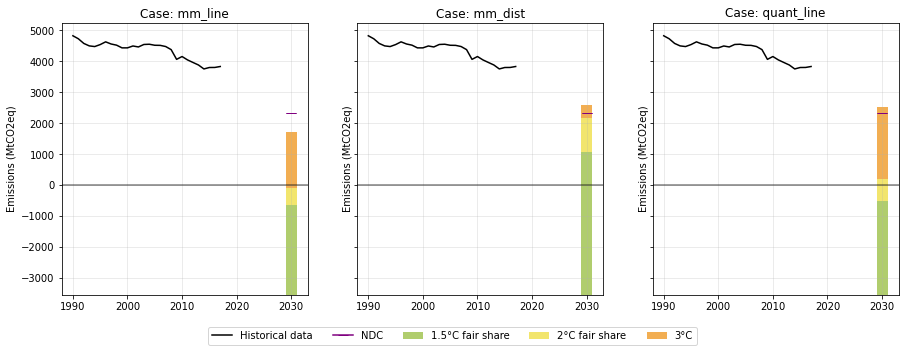

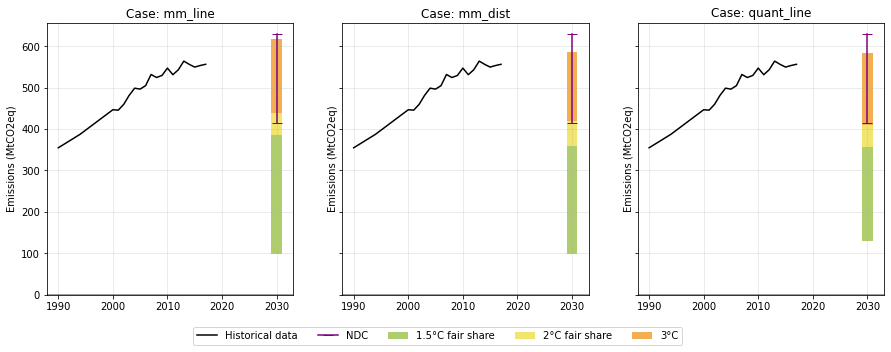

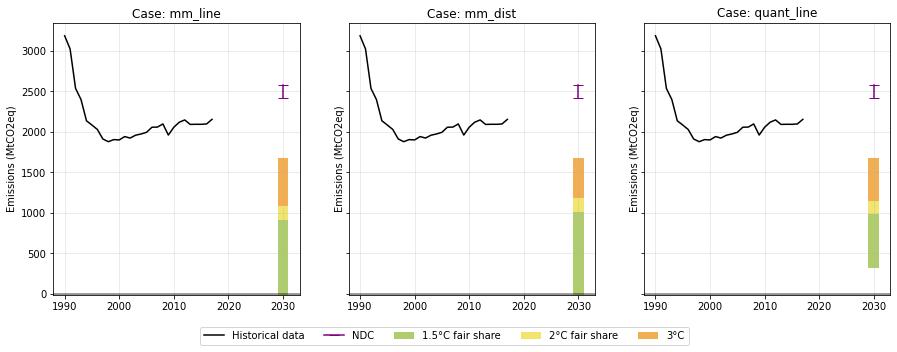

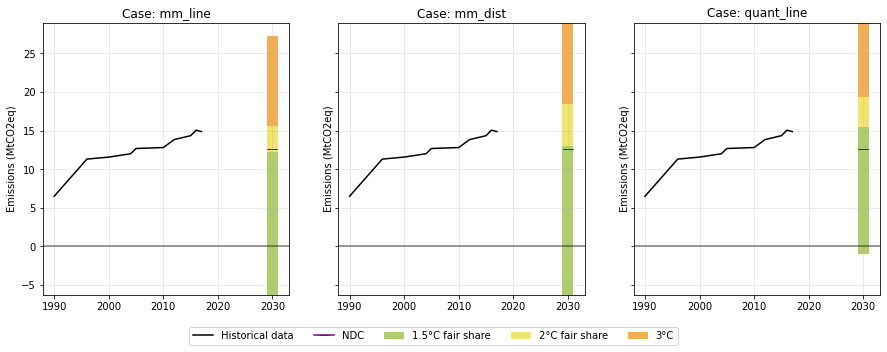

In [19]:
for country in countries_to_analyze:
    plot_fair_share_ndc(country,save=True)

# Composite plot (option 1) 

The first step is to calculate all the NDC emission values as a % reduction over 2010 values

In [21]:
for iso in ndc_data.index:
    for col in ['lo','hi']:
        ndc_data.loc[iso,col] = (ndc_data.loc[iso,col]/df_hist.loc[iso,'2010'] - 1) * 100

In [27]:
mm_line.index.get_level_values('region').unique()

Index(['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG',
       ...
       'VEN', 'VGB', 'VNM', 'VUT', 'WSM', 'YEM', 'ZAF', 'ZMB', 'ZWE', 'EARTH'],
      dtype='object', name='region', length=210)

In [102]:
def process_plot_data(df):
    
    levels = ['2100_GMT<1.5C@P0.5','peak_GMT<2.0C@P0.66','2100_GMT<3.0C@P0.5']
    df = df[
        (df.index.get_level_values('scenario').isin(levels))
        &
        (df.index.get_level_values('region').isin(ndc_data.index))
    ]
    hist = df_hist[df_hist.index.isin(ndc_data.index)]

    for iso,scen in df.index:
        col = '2030_allowances'
        df.loc[iso,scen] = (df.loc[iso,scen] / hist.loc[iso,'2010'] - 1) * 100
    
    df = df.drop(columns = ['2025_allowances', '2050_allowances'])
    
    return df

In [111]:
plot_mm_line = process_plot_data(mm_line)
plot_quant_line = process_plot_data(quant_line)
plot_mm_dist = process_plot_data(mm_dist)

/opt/anaconda3/envs/B2G/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/B2G/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [219]:
iso_mapping = [
    ('IND','red'),
    ('CHN','orange'),
    ('EU27','purple'),
    ('ZAF','xkcd:bluish')
]

In [220]:
def plot_country_scatter(iso,color,levels,ax):
    iso_mm_line = plot_mm_line.loc[iso,:].reset_index().set_index('scenario')
    iso_mm_dist = plot_mm_dist.loc[iso,:].reset_index().set_index('scenario')
    iso_quant_line = plot_quant_line.loc[iso,:].reset_index().set_index('scenario')
    
    for i, temp in enumerate(levels):
        
        xs = [i]
        
        # Linear
        ax.plot(
            xs,
            iso_mm_line.loc[temp,'2030_allowances'],
            marker = '^',
            color = color
        )
        
        # CDF walking
        ax.plot(
            xs,
            iso_mm_dist.loc[temp,'2030_allowances'],
            marker = '*',
            color = color
        )
        
        # Quant linear
        ax.plot(
            xs,
            iso_quant_line.loc[temp,'2030_allowances'],
            marker='o',
            color=color
        )

In [221]:
def plot_ndc_span(iso, color,ax):
    
    xmin = ndc_data.loc[iso,'lo']
    xmax = ndc_data.loc[iso,'hi']
    
    if xmin == xmax:
        ax.axhline(xmin,color=color,weight='bold')
    else:
        ax.axhspan(xmin, xmax, color=color, alpha=0.3)

In [222]:
levels = [
    '2100_GMT<1.5C@P0.5',
    'peak_GMT<2.0C@P0.66',
    '2100_GMT<3.0C@P0.5'
]

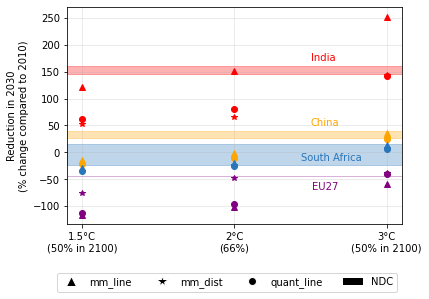

In [239]:
fig, ax = plt.subplots()

# Scatter plot the level
for iso, col in iso_mapping:
    plot_country_scatter(iso, col,levels,ax)
    plot_ndc_span(iso, col, ax)

# Grid
ax.grid(alpha=0.3)
plt.xticks(
    [0,1,2],
    ['1.5°C\n(50% in 2100)','2°C\n(66%)','3°C\n(50% in 2100)']
)

# Add annotations
ax.annotate(
    'India',
    xy = (1.5,ndc_data.loc['IND','hi']+10),
    color = 'red'
)

ax.annotate(
    'China',
    xy = (1.5,ndc_data.loc['CHN','hi']+10),
    color = 'orange'
)

ax.annotate(
    'South Africa',
    xy = (1.44,(ndc_data.loc['ZAF','lo']+ndc_data.loc['ZAF','lo'])/3),
    color = 'xkcd:bluish'
)

ax.annotate(
    'EU27',
    xy = (1.51,ndc_data.loc['EU27','lo']-25),
    color = 'purple'
)
# Labels
ax.set_ylabel('Reduction in 2030\n(% change compared to 2010)')

# Construct legend
legend_elements = [
    Line2D([0],[0],marker='^',color='w',markerfacecolor='black',label='mm_line',markersize=10),
    Line2D([0],[0],marker='*',color='w',markerfacecolor='black',label='mm_dist',markersize=12),
    Line2D([0],[0],marker='o',color='w',markerfacecolor='black',label='quant_line',markersize=8),
    Patch(facecolor='black',label='NDC')
]

ax.legend(handles=legend_elements, bbox_to_anchor=(1,-0.2),ncol=4)

In [234]:
fig.savefig(
    '../figures/s32_trial.png',
    dpi=800,
    bbox_inches='tight'
)